<a href="https://colab.research.google.com/github/fabilj825/EntityLinkerUmls/blob/main/medmentions_and_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

gdrive_base_address = "drive/MyDrive/UMLS/"
dataframes_address = gdrive_base_address + "dataframes/"
knowledgebase_address = gdrive_base_address + "knowledgebase/"
model_address = gdrive_base_address + "model/"

medmentions_path = gdrive_base_address + "MedMentions/full/data/"

USE_SCIBERT = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install spacy[cuda12x]
!pip install kaleido
!pip install python-multipart
!pip install uvicorn
!pip install fastapi
!pip install wandb
!pip install scispacy
!pip install spacy-transformers
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_lg-0.5.3.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_ner_bc5cdr_md-0.5.3.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_scibert-0.5.3.tar.gz



/bin/bash: line 1: virtualenv: command not found
  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.3/en_core_sci_scibert-0.5.3.tar.gz (417.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached scipy-1.10.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1

Usage:   
  pip3 <command> [options]

no such option: --upgrade


In [ ]:
#need a existing kb to filter for entities. specify path to kb
#increases runtime of next cell 6 dramatically
flter_for_kb_entities=False
if flter_for_kb_entities:
    import spacy
    from spacy.kb import InMemoryLookupKB
    nlp = spacy.load("en_core_sci_lg")
    kb = InMemoryLookupKB(vocab=nlp.vocab, entity_vector_length=200)
    kb.from_disk(knowledgebase_address)
    enti=kb.get_entity_strings()

In [5]:
def read_lines(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            yield line.strip()

In [6]:
dataset = []
file_path = medmentions_path + "corpus_pubtator/corpus_pubtator.txt"
same_pmid=False
abstract=False
for line in read_lines(file_path):
    if len(line.split("|")) == 3 and same_pmid == False:
        pmid, type, text = line.split("|")
        if type == 't':
            same_pmid=True
            abstract = False
            mentions={}
            entities=[]
            cuis=[]
    if len(line.split("|")) == 3 and same_pmid == True:
        abstract = line.split("|")[2]
        text_and_abstract=text + ' ' + abstract
        abstract=True
    if len(line.split('\t')) == 6 and same_pmid == True :
        pmid, start, end, mention, semId, cui = line.split('\t')
        if flter_for_kb_entities:
            if cui not in enti:
                continue
        offset=(int(start),int(end))
        links_dict={cui:1.0}
        mentions[offset]=links_dict
        entities.append((int(start),int(end),"ORG"))
        cuis.append(cui)
        abstract=False

    if len(line.split('\t')) == 1 and same_pmid == True and not abstract:
        same_pmid = False
        dataset.append((text_and_abstract,{"links":mentions,"entities":entities},pmid ))

In [8]:
train_dataset = []
test_dataset = []
pmids_train=[]
file_path_train = medmentions_path + "corpus_pubtator_pmids_trng.txt"
for line in read_lines(file_path_train):
    pmids_train.append(line)

pmids_test=[]
file_path_test = medmentions_path + "corpus_pubtator_pmids_test.txt"
for line in read_lines(file_path_test):
    pmids_test.append(line)

for pmid_train in pmids_train:
    train_dataset.extend(data for data in dataset if data[2]==pmid_train)

for pmid_test in pmids_test:
    test_dataset.extend(data for data in dataset if data[2]==pmid_test)

In [10]:
import spacy
if USE_SCIBERT == True:
  nlp=spacy.load("en_core_sci_scibert")
else:
  nlp=spacy.load("en_core_sci_lg")

/usr/local/lib/python3.10/dist-packages/spacy_transformers/layers/hf_shim.py:137: UserWarning: Error loading saved torch state_dict with strict=True, likely due to differences between 'transformers' versions. Attempting to load with strict=False as a fallback...

If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current 'transformers' and 'spacy-transformers' versions. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [11]:
from spacy.training import Example

TRAIN_EXAMPLES = []
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")
sentencizer = nlp.get_pipe("sentencizer")
for text, annotation,_ in train_dataset:

    try:
        example = Example.from_dict(nlp.make_doc(text), annotation)
        example.reference = sentencizer(example.reference)
        TRAIN_EXAMPLES.append(example)
    except:
        continue

In [12]:
from spacy.ml.models import load_kb

entity_linker = nlp.add_pipe("entity_linker", config={"incl_prior": False}, last=True)
entity_linker.initialize(get_examples=lambda: TRAIN_EXAMPLES, kb_loader=load_kb(knowledgebase_address + '/mykb'))

In [13]:
from thinc.api import decaying
from thinc.api import Adam
from thinc.api import RAdam

learn_rates = decaying(0.005, 1e-4)
optimizer = Adam(learn_rate=learn_rates)

In [23]:
from spacy.util import minibatch, compounding
import random

learning_rates = []
losses_list = []

ITER = 1

with nlp.select_pipes(enable=["entity_linker"]):   # train only the entity_linker
    #optimizer = nlp.resume_training()
    print(optimizer)
    # ITERATIONS NEED TO BE CHANGED BEFORE EXECUTION
    for itn in range(ITER):
        print(itn)
        random.shuffle(TRAIN_EXAMPLES)
        batches = minibatch(TRAIN_EXAMPLES, size=compounding(1.0, 32.0, 1.001))  # increasing batch sizes
        losses = {}
        for batch in batches:
            nlp.update(
                batch,
                drop=0.2,      # prevent overfitting
                losses=losses,
                sgd=optimizer,
            )

            learning_rates.append(optimizer.learn_rate)
            losses_list.append(losses["entity_linker"])

        if itn % 10 == 0:
            print(itn, "Losses", losses)   # print the training loss
print(itn, "Losses", losses)

nlp.to_disk(model_address + "my_nlp")

0
0 Losses {'entity_linker': 4.110993485277548}
0 Losses {'entity_linker': 4.110993485277548}


In [ ]:
nlp_addr = model_address + "my_nlp_newADAM_{0}".format("scibert" if USE_SCIBERT == True else "sci_lg")
nlp.to_disk(nlp_addr)

Mention level

In [18]:
detected=[]
annot=[]
for text, true_annot, _ in test_dataset:
  doc = nlp(text)
  entitiesListGOLD=set()
  for link in true_annot["links"].items():
    start=link[0][0]
    end=link[0][1]
    key, _ = list(link[1].items())[0]
    entitiesListGOLD.add((start,end,key))
  entitiesList=set()
  for ent in doc.ents:
    entitiesList.add((ent.start_char,ent.end_char,ent.kb_id_))
  detected.append(entitiesList)
  annot.append(entitiesListGOLD)


tp=0
fn=0
fp=0
for i, enti in enumerate(detected):
  tp=tp+len(enti.intersection(annot[i]))
  fp=fp+len(enti - annot[i])
  fn=fn+len(annot[i] - enti)

recall=tp/(tp+fn)
precision=tp/(tp+fp)
f1=2*((precision*recall)/(precision+recall))
print(recall)
print(precision)
print(f1)

Doc Level


In [ ]:
detected=[]
annot=[]
for text, true_annot, _ in test_dataset:
   # print(true_annot["links"][(0,20)])
    doc = nlp(text)  # to make this more efficient, you can use nlp.pipe() just once for all the texts
    entitiesListGOLD=set()
    for link in true_annot["links"].items():
      key, _ = list(link[1].items())[0]
      entitiesListGOLD.add(key)
    entitiesList=set()
    for ent in doc.ents:
       entitiesList.add(ent.kb_id_)
    detected.append(entitiesList)
    annot.append(entitiesListGOLD)

tp=0
fn=0
fp=0
for i, enti in enumerate(detected):
  tp=tp+len(enti.intersection(annot[i]))
  fp=fp+len(enti - annot[i])
  fn=fn+len(annot[i] - enti)


recall=tp/(tp+fn)
precision=tp/(tp+fp)
f1=2*((precision*recall)/(precision+recall))
print(recall)
print(precision)
print(f1)


18969
0
8418
19917


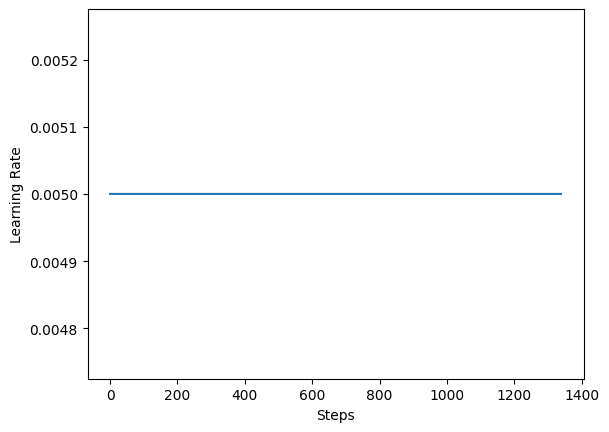

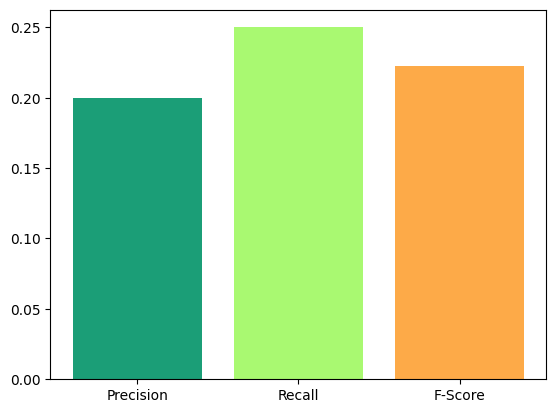

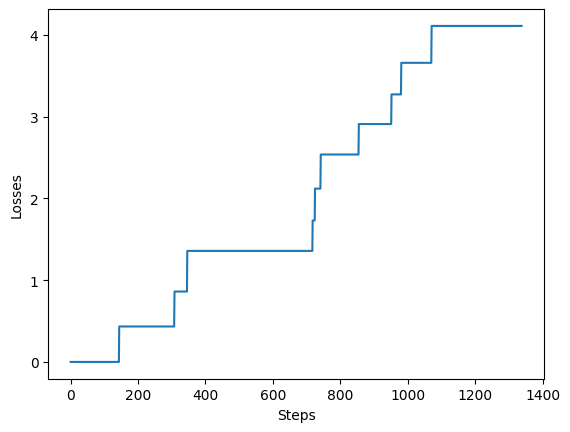

In [26]:
import matplotlib.pyplot as plt


plt.plot(learning_rates)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

metrics = ["Precision", "Recall", "F-Score"]
bar_colors = ['#1b9e77', '#a9f971', '#fdaa48','#6890F0','#A890F0']

values = [precision, recall, f1]

plt.bar(metrics, values, color=bar_colors)
plt.show()

plt.plot(losses_list)
plt.xlabel("Steps")
plt.ylabel("Losses")
plt.show()

# print(recall)
# print(precision)
# print(f1)


In [21]:
from spacy import displacy
doc = nlp("Generalized Epilepsy and Myoclonic Seizures in 22q11.2 Deletion Syndrome Prompted by the observations of juvenile myoclonic epilepsy (JME) in 22q11.2 deletion syndrome (22q11DS) and recurrent copy number variants in genetic generalized epilepsy (GGE), we searched for further evidence supporting a possible correlation of 22q11DS with GGE and with myoclonic seizures. Through routine diagnostics, we identified 3 novel individuals with the seemingly uncommon combination of 22q11DS and JME. We subsequently screened the literature for reports focussing on the epilepsy phenotype in 22q11DS. We additionally screened a database of 173 22q11DS patients and identified a fourth individual with JME as well as 2 additional cases with GGE. We describe 6 novel and 22 published cases with co-occurrence of 22q11DS and GGE. In many patients, GGE was associated with myoclonic seizures allowing for a diagnosis of JME in at least 6 individuals. Seventeen of the 173 22q11DS cases (10%) had a diagnosis of either focal or generalized epilepsy. In these cases, focal epilepsy could often be attributed to syndrome-associated hypocalcaemia, cerebral bleeds, or structural brain anomalies. However, the cause of GGE remained unclear. In this study, we describe and review 28 individuals with 22q11DS and GGE (especially JME), showing that both disorders frequently co-occur. Compared to the reported prevalence of 15-21%, in our case series only 10% of 22q11DS individuals were found to have epilepsy, often GGE. Since 22q11.2 does not contain convincing GGE candidate genes, we discuss the possibility of an aetiological correlation through a possibly disturbed interaction with the GABAB receptor.")
displacy.serve(doc,style="ent")



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.
